# Open-EO compositing

In [1]:
import openeo
import logging

In [2]:
logging.basicConfig(level=logging.DEBUG)

Setup a session, this represents your connection to the backend.

In [3]:
session = openeo.session("nobody", "http://192.168.205.137:8080")

Create a composite based on a Sentinel 2 FAPAR layer that is available in the backend. 
This simply describes the parameters to create the composite, no actual processing occurs yet.

In [49]:
s2_fapar = session.imagecollection("S2_FAPAR")

composite = s2_fapar\
.date_range_filter("2017-04-01","2017-09-10")\
.bbox_filter(left=4.3,right=5.0,top=50.55,bottom=50.28,srs="EPSG:4326")\
.max_time()

Now our composite is ready to download

In [ ]:
composite.download("./openeo-composite.geotiff","geotiff")

DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 192.168.205.137
DEBUG:urllib3.connectionpool:http://192.168.205.137:8080 "POST /openeo/download HTTP/1.1" 200 23605637


In [19]:
!ls -lh openeo-composite.*
!rm openeo-composite.geotiff.aux.xml
!gdalinfo -hist openeo-composite.geotiff

-rw-r--r--. 1 driesj driesj 23M Jan 24 13:13 openeo-composite.geotiff
-rw-r--r--. 1 driesj driesj 878 Jan 24 10:13 openeo-composite.geotiff.aux.xml
Driver: GTiff/GeoTIFF
Files: openeo-composite.geotiff
Size is 7680, 3072
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]
Origin = (4.298130412513061,50.558600934228501)
Pixel Size = (0.000097215289858,-0.000097215289858)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (   4.2981304,  50.5586009) (  4d17'53.27"E, 50d33'30.96"N)
Lower Left  (   4.2981304,  50.2599556) (  4d17'53.27"E, 50d15'35.84"N)
Upper Right (   5.0447438,  50.5586009) (  5d 2'41.08"E, 50d33'30.96"N)
Lower Right (   5.0447438,  50.2599556) (  5d 2'41.08"E, 50d15'35.84"N)
Center      (   

## Getting the timeseries

In [28]:
timeseries = s2_fapar\
.date_range_filter("2017-04-01","2017-09-10")\
.bbox_filter(left=4.3,right=5.0,top=50.55,bottom=50.28,srs="EPSG:4326")\
.timeseries(4.4,50.30,srs="EPSG:4326")
timeseries.json()

DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): 192.168.205.137
DEBUG:urllib3.connectionpool:http://192.168.205.137:8080 "POST /openeo/timeseries/point?x=4.4&y=50.3&srs=EPSG:4326 HTTP/1.1" 200 3086


{'2017-04-03T00:00:00+00:00': [100.0],
 '2017-04-06T00:00:00+00:00': [nan],
 '2017-04-09T00:00:00+00:00': [nan],
 '2017-04-16T00:00:00+00:00': [nan],
 '2017-04-23T00:00:00+00:00': [nan],
 '2017-04-26T00:00:00+00:00': [nan],
 '2017-04-29T00:00:00+00:00': [nan],
 '2017-05-03T00:00:00+00:00': [nan],
 '2017-05-06T00:00:00+00:00': [135.0],
 '2017-05-09T00:00:00+00:00': [nan],
 '2017-05-13T00:00:00+00:00': [112.0],
 '2017-05-16T00:00:00+00:00': [44.0],
 '2017-05-19T00:00:00+00:00': [nan],
 '2017-05-23T00:00:00+00:00': [nan],
 '2017-05-26T00:00:00+00:00': [178.0],
 '2017-05-29T00:00:00+00:00': [nan],
 '2017-06-02T00:00:00+00:00': [61.0],
 '2017-06-05T00:00:00+00:00': [159.0],
 '2017-06-12T00:00:00+00:00': [nan],
 '2017-06-15T00:00:00+00:00': [85.0],
 '2017-06-18T00:00:00+00:00': [nan],
 '2017-06-22T00:00:00+00:00': [80.0],
 '2017-06-25T00:00:00+00:00': [nan],
 '2017-06-28T00:00:00+00:00': [nan],
 '2017-06-30T00:00:00+00:00': [nan],
 '2017-07-02T00:00:00+00:00': [nan],
 '2017-07-03T00:00:00+00

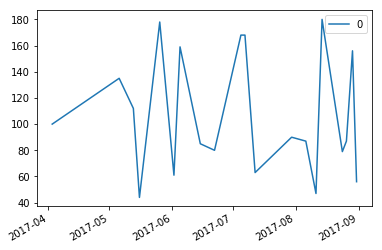

In [47]:
import pandas as pd
series_df = pd.DataFrame.from_dict(timeseries.json(), orient="index")
series_df.index = pd.to_datetime(series_df.index)
import seaborn as sns
%matplotlib inline
series_df.dropna().plot()


In [48]:
series_df.dropna()

,0
2017-07-05,168.0
2017-08-26,87.0
2017-05-13,112.0
2017-05-16,44.0
2017-08-14,180.0
2017-08-29,156.0
2017-08-06,87.0
2017-08-11,47.0
2017-06-05,159.0
2017-07-12,63.0


## Showing the result
Using rasterio, we can load and plot our downloaded file.

In [4]:
import rasterio
%matplotlib inline

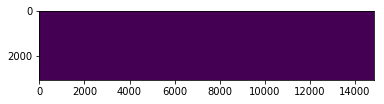

In [13]:
from rasterio.plot import show
from matplotlib import pyplot
composite_local = rasterio.open("./openeo-composite.geotiff")
#fig, ax = pyplot.subplots(1, figsize=(20, 6))
show(composite_local.read(1))
composite_local.close()
#pyplot.show()

DEBUG:rasterio._io:all_valid: False
DEBUG:rasterio._io:mask_flags: [8]


AttributeError: 'MaskedConstant' object has no attribute '_fill_value'